In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
def getDistances(A):
    if not isinstance(A, np.ndarray):
        A = A.values.reshape(-1, A.shape[-1])

    n = A.shape[0]
    Distance = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            Distance[i,j] = np.linalg.norm(A[i] - A[j])
            Distance[j,i] = Distance[i,j]
    return Distance

getDistances(np.array([[1,2,3],[4,5,6],[7,8,9]]))

array([[ 0.        ,  5.19615242, 10.39230485],
       [ 5.19615242,  0.        ,  5.19615242],
       [10.39230485,  5.19615242,  0.        ]])

In [146]:
def getW(D,U,V):
    weight = 0
    for i in U:
        for j in V:
            weight += D[i,j]
    return weight
    

In [147]:
def getWIn(D,C):
    Win = 0
    clusters = set(C)
    for cluster in clusters:
        indices = [i for i, x in enumerate(C) if x == cluster]
        Win += getW(D, indices, indices)
    return round(Win/2, 0)

In [148]:
def getWOut(D,C):
    Wout = 0
    clusters = set(C)
    for cluster in clusters:
        indices = [i for i, x in enumerate(C) if x == cluster]
        for i in indices:
            for j in range(len(D)):
                if j in indices:
                    continue
                Wout += D[i,j]
    return round(Wout/2,0)

In [149]:
def getNIn(C):
    Nin = 0
    clusters = set(C)
    for cluster in clusters:
        n = [i for i, x in enumerate(C) if x == cluster]
        Nin += len(n) * (len(n)-1)/2
    return Nin

In [150]:
def getNOut(C):
    n = len(C)
    Nout = (n*(n-1)/2) - getNIn(C)
    return Nout

In [151]:
import pandas as pd_test
import numpy as np_test
dfIrisTest = pd_test.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
A_Iris_Test = dfIrisTest[dfIrisTest.columns[:4]].astype(float)
C_Iris_Test = dfIrisTest[dfIrisTest.columns[4]]
print(type(A_Iris_Test))
D_Iris_Test = getDistances(A_Iris_Test)
C1 = np.where(C_Iris_Test == 'setosa')[0]
C2 = np.where(C_Iris_Test == 'versicolor')[0]
C3 = np.where(C_Iris_Test == 'virginica')[0]
CList = [C1, C2, C3]

print ("\nTest Weight Measures\n------------------")
expectedW = {
    (0,1): 8246,
    (0,2): 12056,
    (1,2): 4606
}
wSummary = "W: "
wFailed = False
for i in range(3):
    for j in range(i):
        p1 = (i,j)
        p2 = (j,i)
        W1 = np_test.round(getW(D_Iris_Test, CList[i], CList[j]))
        W2 = np_test.round(getW(D_Iris_Test, CList[j], CList[i]))
        if W1 != W2:
            if not wFailed:
                wSummary += "failed"
            wSummary += "\n\tasymmetry of W: " + str(W1) + " != " + str(W2)
            wFailed = True
        
        if W1 != expectedW[p2]:
            if not wFailed:
                wSummary += "failed"
            wSummary += "\n\tunexpected value of W: " + str(W1) + " instead of expected " + str(expectedW[p2])
            wFailed = True
if not wFailed:
    wSummary += "ok"
print(wSummary)
expectedWIn = 3518
expectedWOut = 24908
expectedNIn = 3675
expectedNOut = 7500
print("WIn:", "ok" if np_test.abs(np_test.round(getWIn(D_Iris_Test, C_Iris_Test)) - expectedWIn) < 2 else "failed")
print("WOut:", "ok" if np_test.abs(np_test.round(getWOut(D_Iris_Test, C_Iris_Test)) - expectedWOut) < 2 else "failed")
print("NIn:", "ok" if getNIn(C_Iris_Test) == 3675 else "failed")
print("NOut:", "ok" if getNOut(C_Iris_Test) == 7500 else "failed")

<class 'pandas.core.frame.DataFrame'>

Test Weight Measures
------------------
W: ok
WIn: ok
WOut: ok
NIn: ok
NOut: ok


### 4)

In [152]:
from sklearn.metrics import pairwise_distances

def getBetaCV(A, C):
    D = getDistances(A)

    
    W_in = getWIn(D, C)
    W_out = getWOut(D, C)
    N_in = getNIn(C)
    N_out = getNOut(C)
    
    beta_cv = (W_in / N_in) / (W_out / N_out)
    
    return beta_cv

def getCIndex(A,C):
    
    D = getDistances(A)
    Nin = getNIn(C)
    Win = getWIn(D, C)
    Wflat = np.ravel(D)
    Wmin = np.sum(np.partition(Wflat, int(Nin))[:int(Nin)])
    Wmax = np.sum(np.partition(Wflat, -int(Nin))[-int(Nin):])
    
    CIndex = ((Win - Wmin)/(Wmax - Wmin))/2
    return CIndex


def getNormalizedCut(A, C):
    normalized_cut = 0

    D = getDistances(A)

    clusters = list(set(C))
    cluster_indices = {cluster: [i for i, label in enumerate(C) if label == cluster] for cluster in clusters}

    for cluster_i in clusters:
        w_other_clusters = 0
        vol_cluster_i = 0
        for cluster_j in clusters:
            weight = getW(D, U=cluster_indices[cluster_i], V=cluster_indices[cluster_j])
            if cluster_i != cluster_j:
                w_other_clusters += weight
            vol_cluster_i += weight

        normalized_cut += w_other_clusters / vol_cluster_i

    return normalized_cut

def getDunn(A, C):
  
    D = getDistances(A)  

    n = len(C)

    mask = np.zeros_like(D, dtype=bool)
    
    np.fill_diagonal(mask, True)  
    for i in range(n):
        for j in range(i + 1, n):
            mask[i, j] = mask[j, i] = C[i] == C[j]  

    w_in = D[mask]
    w_max_in = w_in.max()

    w_out = D[~mask]  
    w_min_out = np.min(w_out[w_out != 0])  

    return w_min_out / w_max_in

def getDaviesBouldin(A, C):
    A = np.array(A)

    indexesClusters = list(set(C))
    k = len(indexesClusters)
    dataCluster = []
    centroidCluster = []
    varianceCluster = []
    Rij = []
    DBIndex = 0

    for i, indexer in enumerate(indexesClusters):
        
        dataCluster.append(A[C == indexer]) #Datos por cluster para la media
        centroidCluster.append(np.mean(dataCluster[i], axis=0)) #Centroide de cada cluster
        varI=np.linalg.norm(np.std(dataCluster[i],axis=0))
        varianceCluster.append(varI) #Varianza de cada cluster

    DBIndex = 0
    for i in range(k):
        Rij = []
        for j in range(k):
            if i != j:
                perCluster = (varianceCluster[i] + varianceCluster[j]) / np.linalg.norm(centroidCluster[i] - centroidCluster[j])
                Rij.append(perCluster)
        DBIndex += max(Rij)

    DBIndex /= k
    return DBIndex

def getSilhouette(A, C):
    A = np.array(A)
    indexesClusters = list(set(C))
    k = len(indexesClusters)
    dataCluster = []

    for i, indexer in enumerate(indexesClusters):
        dataCluster.append(A[C == indexer])
    
    silhouette = 0
    for i in range(k):
        if len(dataCluster[i]) > 1:
            for index_point_ClusterI in range(len(dataCluster[i])):
                b_candidates = [np.linalg.norm(dataCluster[i][index_point_ClusterI] - dataCluster[l], axis=1).mean() for l in range(k) if l != i and len(dataCluster[l]) > 1]
                if len(b_candidates) > 0:
                    b = np.min(b_candidates)
                    a = np.linalg.norm(dataCluster[i][index_point_ClusterI]-dataCluster[i], axis=1)
                    a = np.sum(a) / (len(dataCluster[i]) - 1)
                    silhouette += (b - a) / max(a, b)
    silhouette /= len(A)
    return silhouette



A_Iris_Test = dfIrisTest[dfIrisTest.columns[:4]].astype(float)
C_Iris_Test = dfIrisTest[dfIrisTest.columns[4]]
getSilhouette(A_Iris_Test, C_Iris_Test)

def getMetric(A, C, metric):
    if metric == "cindex":
        return getCIndex(A, C)
    elif metric == "beta":
        return getBetaCV(A, C)
    elif metric == "nc":
        return getNormalizedCut(A, C)
    elif metric == "db":
        return getDaviesBouldin(A, C)
    elif metric == "sil":
        return getSilhouette(A, C)
    elif metric == "dunn":
        return getDunn(A, C)
    else:
        return None


In [153]:
import pandas as pd_test
import numpy as np_test
dfIrisTest = pd_test.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
A_Iris_Test = dfIrisTest[dfIrisTest.columns[:4]].astype(float)
C_Iris_Test = dfIrisTest[dfIrisTest.columns[4]]
D_Iris_Test = getDistances(A_Iris_Test)
display(A_Iris_Test)

# Test metrics
print ("\nTest Metrics\n------------------")
expected = {
    "beta": 0.2882861014913346,
    "cindex": 0.046803774122703735,
    "nc": 2.6150343040385264,
    "dunn": 0.05848053214719304,
    "db": 0.8445815484442534,
    "sil": 0.5032506980665507
}
for m in expected:
    e = np.round(expected[m], 2)
    a = getMetric(A_Iris_Test, C_Iris_Test, m)
    a = np.round(a, 2) if not a is None else None
    print(m + ":\t", "ok" if e == a else "failed. Expected " + str(e) + " but saw " + str(a))

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3



Test Metrics
------------------
beta:	 ok
cindex:	 ok
nc:	 ok
dunn:	 ok
db:	 ok
sil:	 ok


In [154]:
def kMeans(D,k,eps=0.01,mu=None,max_iter=20):
 d=D.shape[1]
 if mu is None:
  mu=np.random.rand(k,d)*(np.max(D,axis=0)-np.min(D,axis=0))+np.min(D,axis=0)
 if type(mu)==list:
  mu=np.array(mu)
 s=False
 g=0
 while not s:
  C=[np.argmin([np.linalg.norm(mu[j]-x)for j in range(k)if not any(np.isnan(mu[j]))])for x in D]
  n=np.zeros(mu.shape)
  s=True
  for i in range(k):
   J=[D[j]for j in range(len(D))if C[j]==i]
   if len(J)>0:
    n[i]=np.mean(J,axis=0)
   else:
    n[i]=np.random.rand(1,d)*(np.max(D,axis=0)-np.min(D,axis=0))+np.min(D,axis=0)
   if np.linalg.norm(mu[i]-n[i])>eps:
    s=False
  mu=n
  g+=1
  if g>=max_iter:
   s=True
 return C,mu

In [155]:
import numpy as np
from scipy.spatial import distance
import seaborn as sns

def DBSCAN(D, epsilon, minpts):
    
    def find_distance(x):
        return distance.squareform(distance.pdist(x))

    def find_neighbors(x, epsilon):
        return np.where(x <= epsilon)[0]

    def expand_cluster(neighbors, cluster, labels, minpts):
        for neighbor in neighbors:
            if labels[neighbor] == -1:
                labels[neighbor] = cluster
                neighbor_neighbors = find_neighbors(dist_matrix[neighbor], epsilon)
                if len(neighbor_neighbors) >= minpts:
                    labels = expand_cluster(neighbor_neighbors, cluster, labels, minpts)
        return labels

    dist_matrix = find_distance(D)
    cluster = -1
    n_obs = D.shape[0]
    labels = np.full(n_obs, -1)
    for i in range(n_obs):
        if labels[i] == -1:
            neighbors = find_neighbors(dist_matrix[i], epsilon)
            if len(neighbors) > minpts:
                cluster += 1
                labels[i] = cluster
                labels = expand_cluster(neighbors, cluster, labels, minpts)
            else:
                labels[i] = -1  
    return labels

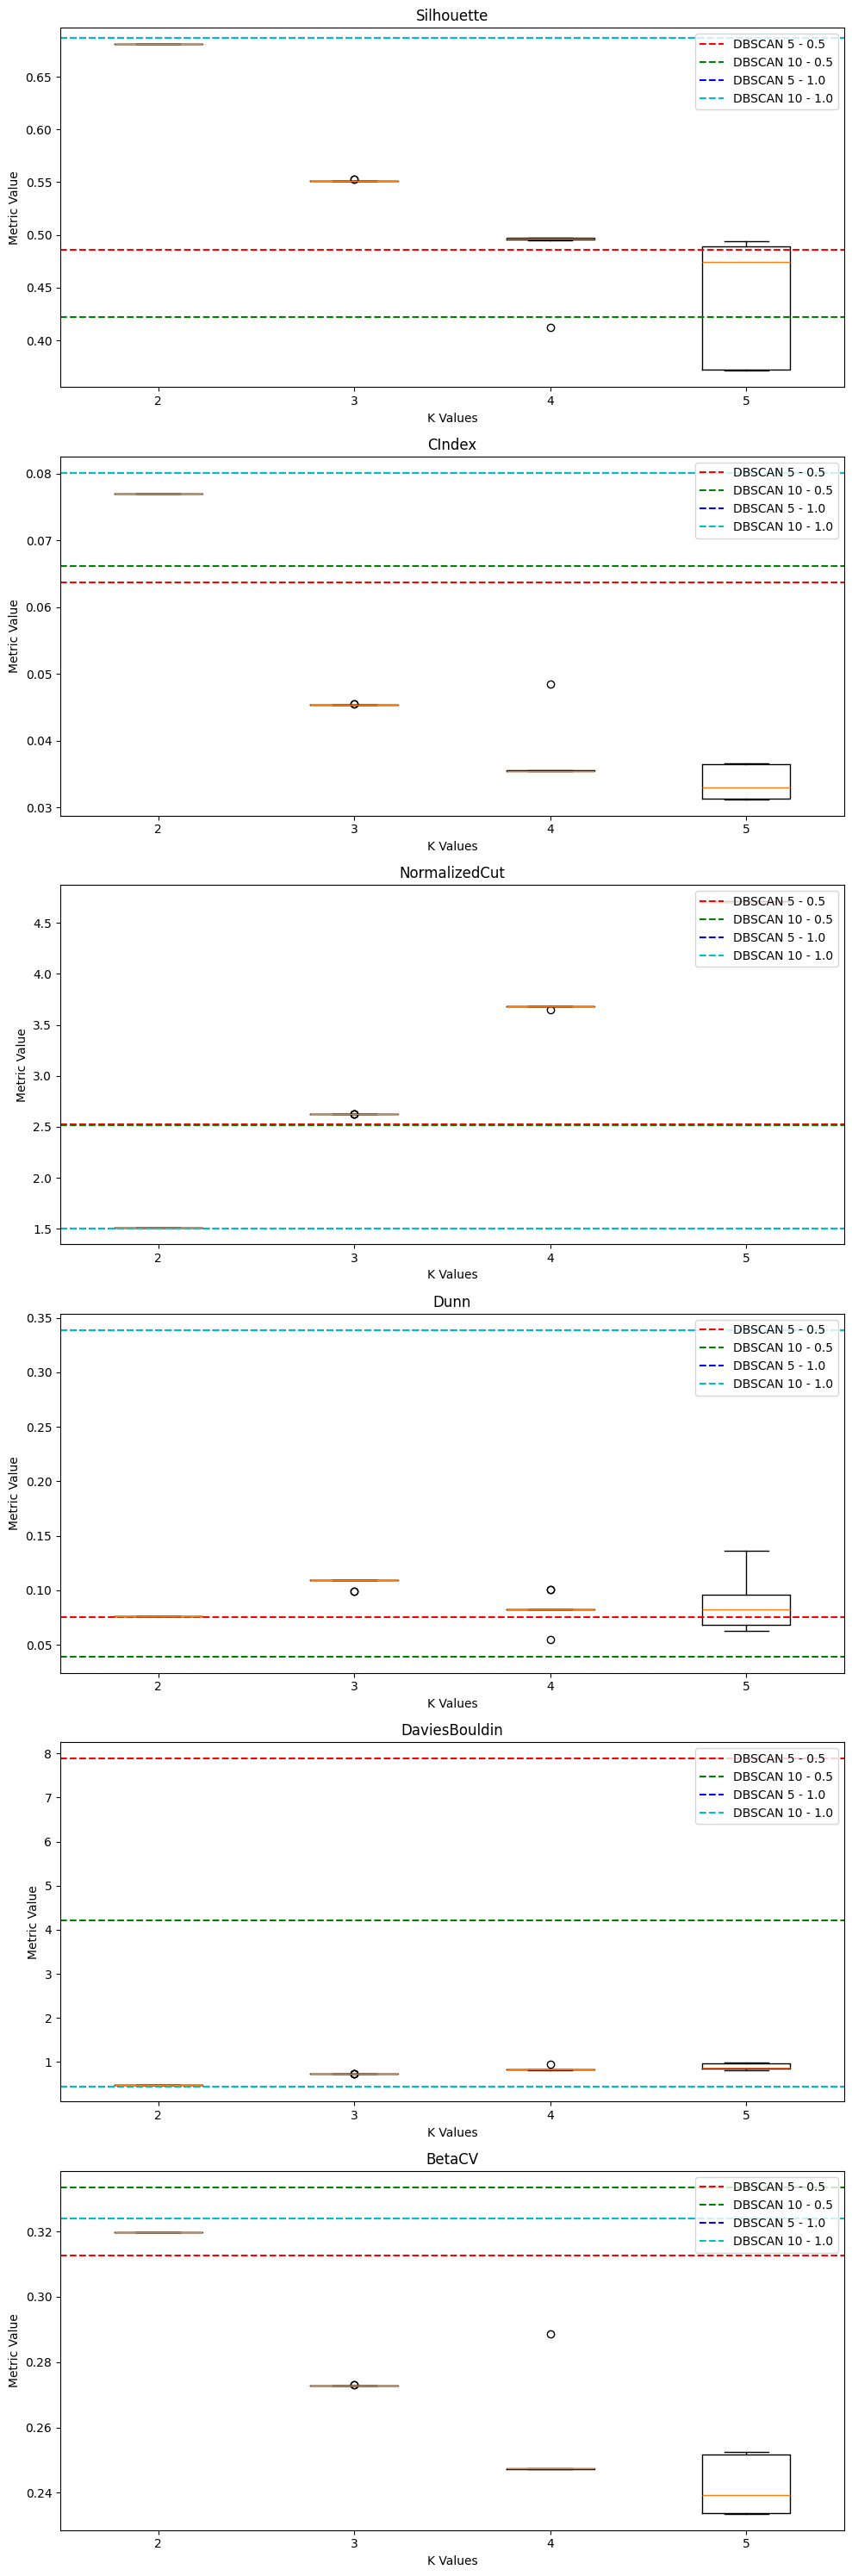

In [156]:
import matplotlib.pyplot as plt
import numpy as np

def plotMetrics(D, l=10, kmeans_eps=0.01, dbscan_configs=[(5, 0.5), (10, 0.5), (5, 1.0), (10, 1.0)]):
    k_values = [2, 3, 4, 5]
    metrics = ['Silhouette', 'CIndex', 'NormalizedCut', 'Dunn', 'DaviesBouldin', 'BetaCV']
    kmeans_metrics = {metric: {} for metric in metrics}
    dbscan_metrics = {metric: {} for metric in metrics}

    for metric in metrics:
        for k in k_values:
            kmeans_metrics[metric][k] = []
            dbscan_metrics[metric][k] = []

    for k in k_values:
        # Only K-Means
        for _ in range(l):
            cluster, _ = kMeans(D, k, kmeans_eps, None)
            for metric in metrics:
                metric_values = None
                if metric == 'Silhouette':
                    metric_values = getSilhouette(D, cluster)
                elif metric == 'CIndex':
                    metric_values = getCIndex(D, cluster)
                elif metric == 'NormalizedCut':
                    metric_values = getNormalizedCut(D, cluster)
                elif metric == 'Dunn':
                    metric_values = getDunn(D, cluster)
                elif metric == 'DaviesBouldin':
                    metric_values = getDaviesBouldin(D, cluster)
                elif metric == 'BetaCV':
                    metric_values = getBetaCV(D, cluster)
                
                # Almacenamos los valores de la métrica en el diccionario de kmeans_metrics
                kmeans_metrics[metric][k].append(metric_values)
        #Now lets do DBSCAN SUIUUUUU
        for minpts, eps in dbscan_configs:

            cluster = DBSCAN(D, eps, minpts)
            for metric in metrics:
                metric_values = None
                if metric == 'Silhouette':
                    metric_values = getSilhouette(D, cluster)
                elif metric == 'CIndex':
                    metric_values = getCIndex(D, cluster)
                elif metric == 'NormalizedCut':
                    metric_values = getNormalizedCut(D, cluster)
                elif metric == 'Dunn':
                    metric_values = getDunn(D, cluster)
                elif metric == 'DaviesBouldin':
                    metric_values = getDaviesBouldin(D, cluster)
                elif metric == 'BetaCV':
                    metric_values = getBetaCV(D, cluster)
                
                # Almacenamos los valores de la métrica en el diccionario de kmeans_metrics
                dbscan_metrics[metric][k].append(metric_values)

    fig, axes = plt.subplots(6, figsize=(10, 30))
    axes = axes.flatten()
    colors = ['r', 'g', 'b', 'c', 'm']
    lines = []
    labels = [f'DBSCAN {minpts} - {eps}' for minpts, eps in dbscan_configs]
    
    for i, (metric, cluster_values) in enumerate(kmeans_metrics.items()):
        ax = axes[i]
        ax.set_title(metric)
        ax.set_xlabel('K Values')
        ax.set_ylabel('Metric Value')

        boxplot_data = [cluster_values[k] for k in k_values]
        ax.boxplot(boxplot_data, labels=k_values)

        # Agregar líneas horizontales para DBSCAN y almacenarlas en la lista
        lines = []  # Lista para almacenar las líneas horizontales
        for j, (minpts, eps) in enumerate(dbscan_configs):
            line = ax.axhline(dbscan_metrics[metric][k_values[j]][j], color=colors[j], linestyle='--')
            lines.append(line)
        ax.legend(lines, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

    
# Mall = pd.read_csv('./Mall_Customers.csv')
# Mall = Mall.drop(columns=['CustomerID'])
# Mall = Mall.drop(columns=['Gender'])
# Mall = np.array(Mall)
# plotMetrics(Mall)

Iris = pd.read_csv('./iris.csv')
Iris = Iris.drop(columns=['species'])
Iris = np.array(Iris)
plotMetrics(Iris)
